In [4]:
from dask.distributed import Client
from sklearn.linear_model import LogisticRegression
from dpyacl.experiment import ExperimentAnalyserFactory

client = Client("tcp://192.168.2.100:8786")
client

Client Scheduler: tcp://192.168.2.100:8786 Dashboard: http://192.168.2.100:8787/status,Cluster Workers: 3 Cores: 6 Memory: 60.00 GB


In [5]:
import dask.array as da

from sklearn.datasets import  make_classification
from dpyacl.strategies.single_label import QueryMarginSampling
from dpyacl.core.stop_criteria import MaxIteration
from dpyacl.experiment.context import HoldOutExperiment
from dpyacl.metrics import Accuracy
from dpyacl.metrics.evaluation import F1, Precision, Recall
from dpyacl.oracle import SimulatedOracleQueryIndex
from dpyacl.scenario.scenario import PoolBasedSamplingScenario

from dpyacl.core.misc import split


In [9]:
_split_count = 1
_feature_num = 10
_label_num = 3
_instance_num = 1000

_X, _y = make_classification(n_samples=_instance_num, n_features=_feature_num, n_informative=2*_label_num, n_redundant=_label_num,
                             n_repeated=0, n_classes=_label_num, n_clusters_per_class=_label_num, weights=None,
                             flip_y=0.01,
                             class_sep=1.0,
                             hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)

_X = da.from_array(_X, chunks="64MB")
_y = da.from_array(_y, chunks="64MB")

_X

dask.array<array, shape=(1000, 10), dtype=float64, chunksize=(1000, 10), chunktype=numpy.ndarray>

In [14]:
%%time
train_idx, test_idx, label_idx, unlabel_idx = split(X=_X,
                                                    y=_X,
                                                    all_class=True,
                                                    split_count=_split_count,
                                                    test_ratio=0.3,
                                                    initial_label_rate=0.05)

train_idx, test_idx, label_idx, unlabel_idx



CPU times: user 33.5 ms, sys: 170 µs, total: 33.6 ms
Wall time: 88.2 ms


([array([252, 984, 175, 816, 373, 668, 313, 137, 185,  74, 390, 182, 636,
         358, 140, 515, 183, 442, 880, 903, 518, 300, 106, 375, 653, 193,
         470, 572, 287, 451, 213,  60, 821, 346, 950, 253, 342, 319, 485,
         444, 347, 536, 732, 626, 162, 414, 989, 663, 734, 331, 412, 244,
         531, 935, 960, 811, 288,  20, 835, 924, 841, 570, 437, 298, 486,
          68, 305, 261, 871, 794, 805, 934, 184, 433, 944, 591, 877, 697,
         675,  18, 708, 368, 132, 799, 671, 674, 798, 557, 565, 963, 148,
         449, 945, 381, 267, 238, 232, 460,   9, 156,  55, 599, 435, 721,
         938, 180, 642, 277, 325, 700, 351, 941,  15, 896, 910, 587, 834,
         282, 501, 424,  28, 849, 764, 664, 159, 149, 745, 359, 455, 119,
         384, 933, 979, 608, 719, 614, 567, 782, 361,  34, 112, 371,  87,
         931, 135, 241, 443, 468, 926, 457, 338, 914, 395, 426, 818, 283,
         884,  61, 181, 788, 216, 192, 888, 992, 523, 707, 167, 727, 561,
         940, 742, 928, 855, 254, 819,

In [15]:
ml_technique = LogisticRegression(solver='liblinear')
stopping_criteria = MaxIteration(50)
query_strategy =  QueryMarginSampling()
performance_metrics = [
                Accuracy(),
                F1(average='macro'),
                Precision(average='macro'),
                Recall(average='macro')]

experiment = HoldOutExperiment(
    _X,
    _y,
    scenario_type=PoolBasedSamplingScenario,
    train_idx=train_idx,
    test_idx=test_idx,
    label_idx=label_idx,
    unlabel_idx=unlabel_idx,
    ml_technique=ml_technique,
    performance_metrics=performance_metrics,
    query_strategy=query_strategy,
    oracle=SimulatedOracleQueryIndex(labels=_y),
    stopping_criteria=stopping_criteria,
    self_partition=False
)

In [16]:
result = experiment.evaluate(verbose=True)

distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-f05ba4d7ed284eccc441a13a763462f0', 0)": ()}
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-f05ba4d7ed284eccc441a13a763462f0', 0)": ()}
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-f05ba4d7ed284eccc441a13a763462f0', 0)": ()}
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-f05ba4d7ed284eccc441a13a763462f0', 0)": ()}
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-f05ba4d7ed284eccc441a13a763462f0', 0)": ()}
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-f05ba4d7ed284eccc441a13a763462f0', 0)": ()}
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-f05ba4d7ed284eccc441a13a763462f0', 0)": ()}
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-f05ba4d7ed284eccc441a13a763462f0', 0)": ()}
distribu

Label: [0], Cost: [1]

| round | initially labeled data | number of queries | cost | accuracy_score: |  f1_score:   | precision_score: | recall_score: |
|   0   |    35 (5.00% of all)   |         1         |  0   |   0.630 ± 0.00  | 0.632 ± 0.00 |   0.640 ± 0.00   |  0.631 ± 0.00 |Label: [0], Cost: [1]
|   0   |    35 (5.00% of all)   |         2         |  0   |   0.638 ± 0.01  | 0.639 ± 0.01 |   0.648 ± 0.01   |  0.639 ± 0.01 |Label: [0], Cost: [1]
|   0   |    35 (5.00% of all)   |         3         |  0   |   0.642 ± 0.01  | 0.642 ± 0.01 |   0.653 ± 0.01   |  0.644 ± 0.01 |Label: [1], Cost: [1]
|   0   |    35 (5.00% of all)   |         4         |  0   |   0.644 ± 0.01  | 0.644 ± 0.01 |   0.658 ± 0.01   |  0.646 ± 0.01 |Label: [2], Cost: [1]
|   0   |    35 (5.00% of all)   |         5         |  0   |   0.645 ± 0.01  | 0.644 ± 0.01 |   0.661 ± 0.01   |  0.647 ± 0.01 |Label: [2], Cost: [1]
|   0   |    35 (5.00% of all)   |         6         |  0   |   0.648 ± 0.01  | 0.647 ± 0.01

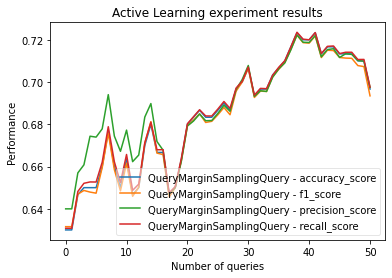

In [17]:
query_analyser = ExperimentAnalyserFactory.experiment_analyser(
                            performance_metrics= [metric.metric_name for metric in performance_metrics],
                            method_name=query_strategy.query_function_name,
                            method_results=result,
                            type="queries"
                        )

# get a brief description of the experiment
query_analyser.plot_learning_curves(title='Active Learning experiment results')

